# Table of Contents

## 1 Data Import
#### 1.1 Importing Python Libraries
#### 1.2 Importing Excel Data <br>

## 2 Defining Global Parameters
#### 2.1 Time Related Parameters
#### 2.2 Finance Related Parameters
#### 2.3 Traffic Projections 
#### 2.4 Port Element Specification
#### 2.5 Existing Port Infrastructure<br>

## 3 Cash Flows
#### 3.1 Revenue Calculations
#### 3.2 Capex Calculations
#### 3.3 Opex Calclulations
#### 3.4 Demurrage Cost Calculations
#### 3.5 Residual Asset Calculations <br>

## 4 Port Optimization
<br>

# 1 Data Import
- 1.1 Importing Python Libraries
- 1.2 Importing Excel Data

In [1]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## 1.1 Importing Python Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
import itertools
from sys import getsizeof
import timeit

## 1.2 Importing Excel Data 

In [3]:
################################################################################

# Read excel data

df_tf                = pd.read_excel ('Excel_input.xlsx', 'TF')
df_vs                = pd.read_excel ('Excel_input.xlsx', 'Vessel specs')
df_vd                = pd.read_excel ('Excel_input.xlsx', 'Vessel distribution')
df_single_parameters = pd.read_excel ('Excel_input.xlsx', 'Single parameters')
df_equipment_specs   = pd.read_excel ('Excel_input.xlsx', 'Equip specs')
df_handling_fees     = pd.read_excel ('Excel_input.xlsx', 'Handling fees')
df_equipment_input   = pd.read_excel ('Excel_input.xlsx', 'Handling fees')
df_ownership         = pd.read_excel ('Excel_input.xlsx', 'Ownership')
df_existing_port     = pd.read_excel ('Excel_input.xlsx', 'Existing port')
df_unloaders         = pd.read_excel ('Excel_input.xlsx', 'Unloaders')
df_depreciation      = pd.read_excel ('Excel_input.xlsx', 'Depreciation')

################################################################################

# Dataframe lookup function

def lookup(aspect,dataframe,jumps):  
    for i in range (len(dataframe)):
        if dataframe.iloc [i,0] == aspect:
            return dataframe.iloc[i,jumps]
        
################################################################################

# 2 Defining Global Parameters
- 2.1 Time Related Parameters
- 2.2 Traffic Projections
- 2.3 Finance Related Parameters
- 2.4 Port Element Specifications

## 2.1 Time Related Parameters

In [4]:
################################################################################################################################

# Time related parameters

start_year = df_tf.iloc [0,0]
end_year   = 2025 #df_tf.iloc [(len(df_tf)-1),0]
n_years    = int(end_year - start_year + 1)
n_a        = int(df_single_parameters.iloc [0,1]) 

################################################################################################################################

## 2.2 Traffic Projections
- 2.2.1 Traffic Forecast
- 2.2.2 Traffic Throughput

### 2.2.1 Traffic forecast 

In [5]:
# Traffic forecast (Excel input)

tf_maize    = np.zeros(n_years)
tf_soybeans = np.zeros(n_years)
tf_wheat    = np.zeros(n_years)
tf_total    = np.zeros(n_years)

for i in range(n_years):
    tf_maize[i]    = df_tf.iloc[i,1]
    tf_soybeans[i] = df_tf.iloc[i,2]
    tf_wheat[i]    = df_tf.iloc[i,3]

# Throughput per commodity in vector form
tf_maize_vector    = tf_maize.reshape((-1, 1)) 
tf_soybeans_vector = tf_soybeans.reshape((-1, 1))
tf_wheat_vector    = tf_wheat.reshape((-1, 1))
tf_total_vector    = tf_maize + tf_soybeans + tf_wheat

def tf_maize(t):
    return tf_maize_vector[t]

def tf_soybeans(t):
    return tf_soybeans_vector[t]

def tf_wheat(t):
    return tf_wheat_vector[t]

def tf_total(t):
    return tf_total_vector[t]

### 2.2.2 Traffic throughput 

In [6]:
# Traffic throughput

def throughput_maize(t):
    return tf_maize(t)    * cdr

def throughput_soybeans(t):
    return tf_soybeans(t) * cdr

def throughput_wheat(t):
    return tf_wheat(t)    * cdr

def throughput(t):
    return tf_maize(t) + tf_soybeans(t) + tf_wheat(t)

## 2.3 Finance Related Parameters
- 2.3.1 WACC calc (linked to ownership)
- 2.3.2 Depreciation calc 
- 2.3.3 Escalation calc
- 2.3.4 Inflation correction (for historic prices) 
- 2.3.5 Currency exchange rate (€ : $)

### 2.3.1 WACC calculation

In [7]:
################################################################################

# Ownership of the different terminal elements

def ownership (aspect):
    
    for i in range (len(df_ownership)):
        if df_ownership.iloc [i,0] == aspect:
            return df_ownership.iloc[i,1]

################################################################################

# The nominal WACC of both entities (Port Authority and Terminal Operator)

real_WACC_PA   = df_single_parameters.iloc [1,1]
real_WACC_TO   = df_single_parameters.iloc [10,1]
inflation_rate = df_single_parameters.iloc [2,1]
PA_WACC        = np.zeros (n_years)
TO_WACC        = np.zeros (n_years)

for i in range (n_years):
    PA_WACC[i] = 1 / ((1 + real_WACC_PA + inflation_rate)**(i))
    TO_WACC[i] = 1 / ((1 + real_WACC_TO + inflation_rate)**(i))

PA_WACC = PA_WACC.reshape((-1, 1))
TO_WACC = TO_WACC.reshape((-1, 1))
        
################################################################################

# Determining the applicable WACC in a specific year

def WACC(aspect):
    
    if ownership(aspect) == 'Port authority':
        return PA_WACC
    if ownership(aspect) == 'Terminal operator':
        return TO_WACC
    
################################################################################

### 2.3.2 Depreciation calculation

In [8]:
################################################################################################################################

# Annual depreciation

def depreciation(aspect):
    rate = lookup(aspect,df_depreciation,1)
    depreciation_vector = np.zeros(t+1)
    for i_1 in range (t+1):
        depreciation_vector[i_1] = 1 - (t-i_1) * rate
    return depreciation_vector

################################################################################################################################

# Selling penalty

def selling_penalty(aspect):
    penalty = lookup(aspect,df_depreciation,2)
    return penalty

################################################################################################################################

### 2.3.3 Escalation calculation

In [9]:
# Defining all escalation factors

def escalation_rate(aspect):
    
    for i in range (len(df_single_parameters)):
        if df_single_parameters.iloc [i,0] == aspect:
            return df_single_parameters.iloc[i,1]
        
def escalation(aspect):
    
    escalation_factor = np.zeros (n_years)
    for i in range (n_years):
        escalation_factor[i] = (1 + escalation_rate(aspect))**(i)  
    return escalation_factor.reshape(-1,1)

### 2.3.4 Inflation correction for historic prices

In [10]:
################################################################################################################################

# Euro inflation adjustment (source: ECB)

def adjustment_factor_euro(year):
    inflation_data = [1.20, 1.54, 0.24, 0.01, 0.44, 1.35, 2.50, 2.71, 1.62, 0.29, 3.29, 2.13, 2.19, 2.18, 2.14, 2.08, 2.27, 2.36, 2.11, 1.08, 1.09, 1.58]
    data = np.zeros(2018 - year + 1)
    for i in range (2018 - year + 1):
        data[i] = 1+(inflation_data[i]/100)
    return np.prod(data)

################################################################################################################################

# Dollar inflation adjustment (source: IMF)

def adjustment_factor_dollar(year):
    inflation_data = [2.34, 1.78, 0.45, 0.06, 0.45, 1.35, 2.45, 2.74, 1.62, 0.42, 3.09, 2.28, 2.19, 2.30, 2.22, 2.07, 2.29, 2.30, 2.21, 1.23, 1.13, 1.58]
    data = np.zeros(2018 - year + 1)
    for i in range (2018 - year + 1):
        data[i] = 1+(inflation_data[i]/100)
    return np.prod(data)

################################################################################################################################

### 2.3.5 Currency exchange rate (€ : $)

In [11]:
# Euro to dollar exchange (source: ECB and averaged over 2018)

def Euro_to_dollars(euros):
    exchange_rate = 1.1924
    return euros * exchange_rate

## 2.4 Port Element Specifications
- 2.4.1 Vessel specifications
- 2.4.2 Quay wall specifications
- 2.4.3 Unloader specifications
- 2.4.4 Bunker specifications
- 2.4.5 Conveyor specifications 
- 2.4.6 Storage specifications 
- 2.4.7 Loading station specifications

### 2.4.1 Vessel Specifications
- 2.4.1.1 Vessel specs
- 2.4.1.2 Throughput distibution over vessel types

###### 2.4.1.1 Vessel specs

In [12]:
################################################################################################################################

# Handysize specifications

handysize_call_size    = df_vs.iloc [0,1]
handysize_LOA          = df_vs.iloc [1,1]
handysize_draft        = df_vs.iloc [2,1]
handysize_beam         = df_vs.iloc [3,1]
handysize_turn_time    = df_vs.iloc [5,1]
handysize_mooring_time = df_vs.iloc [6,1]
handysize_demurrage    = df_vs.iloc [7,1]

################################################################################################################################

# Handymax specifications

handymax_call_size     = df_vs.iloc [0,2]
handymax_LOA           = df_vs.iloc [1,2]
handymax_draft         = df_vs.iloc [2,2]
handymax_beam          = df_vs.iloc [3,2]
handymax_turn_time     = df_vs.iloc [5,2]
handymax_mooring_time  = df_vs.iloc [6,2]
handymax_demurrage     = df_vs.iloc [7,2]

################################################################################################################################

# Panamax specifications

panamax_call_size      = df_vs.iloc [0,3]
panamax_LOA            = df_vs.iloc [1,3]
panamax_draft          = df_vs.iloc [2,3]
panamax_beam           = df_vs.iloc [3,3]
panamax_turn_time      = df_vs.iloc [5,3]
panamax_mooring_time   = df_vs.iloc [6,3]
panamax_demurrage      = df_vs.iloc [7,3]

################################################################################################################################

###### 2.4.1.2 Throughput distribution over vessel types

In [13]:
# Vessel modal split per vesseltype per commodity

distribution_maize_handysize    = np.zeros(n_years)
distribution_maize_handymax     = np.zeros(n_years)
distribution_maize_panamax      = np.zeros(n_years)
distribution_soybeans_handysize = np.zeros(n_years)
distribution_soybeans_handymax  = np.zeros(n_years)
distribution_soybeans_panamax   = np.zeros(n_years)
distribution_wheat_handysize    = np.zeros(n_years)
distribution_wheat_handymax     = np.zeros(n_years)
distribution_wheat_panamax      = np.zeros(n_years)

for i in range(n_years):
    distribution_maize_handysize[i]    = df_vd.iloc [i,2]
    distribution_maize_handymax[i]     = df_vd.iloc [i,3]
    distribution_maize_panamax[i]      = df_vd.iloc [i,4]

    distribution_soybeans_handysize[i] = df_vd.iloc [i,6]
    distribution_soybeans_handymax[i]  = df_vd.iloc [i,7]
    distribution_soybeans_panamax[i]   = df_vd.iloc [i,8]
    
    distribution_wheat_handysize[i]    = df_vd.iloc [i,10]
    distribution_wheat_handymax[i]     = df_vd.iloc [i,11]
    distribution_wheat_panamax[i]      = df_vd.iloc [i,12]

def percentage_maize_handysize(t):
    return distribution_maize_handysize[t]  
def percentage_maize_handymax(t):
    return distribution_maize_handymax[t]
def percentage_maize_panamax(t):
    return distribution_maize_panamax[t]    
def percentage_soybeans_handysize(t):
    return distribution_soybeans_handysize[t]    
def percentage_soybeans_handymax(t):
    return distribution_soybeans_handymax[t]   
def percentage_soybeans_panamax(t):
    return distribution_soybeans_panamax[t]    
def percentage_wheat_handysize(t):
    return distribution_wheat_handysize[t]    
def percentage_wheat_handymax(t):
    return distribution_wheat_handymax[t]    
def percentage_wheat_panamax(t):
    return distribution_wheat_panamax[t]    

################################################################################################################################

### 2.4.2 Quay Wall Specifications
- 2.4.2.1 Unit price 
- 2.4.2.2 Mobilisations costs

###### 2.4.2.1 Quay wall unit price

###### 2.4.2.2 Quay wall mobilisation costs

### 2.4.3 Unloader Specifications
- 2.4.3.1 Capacity
- 2.4.3.2 Unit price
- 2.4.3.3 Mobilisations costs
- 2.4.3.4 Operational costs

###### 2.4.3.1 Unloader capacity

In [14]:
# Unloader capacity

def capacity_unloaders():
    
    unloader_type = lookup('Unloader type',df_unloaders,1)
  
    if unloader_type == 'Gantry crane':
        lifting_capacity   = 50
        payload            = 0.70 * lifting_capacity    #Source: Nemag
        hourly_cycles      = 60                         #Source: Nemag
        peak_capacity      = payload * hourly_cycles    #Or as direct input 
        effective_capacity = 0.60 * peak_capacity       #Source: TATA steel
        #weight            = KN / m2
        #annual_maintenance=
        return effective_capacity

    if unloader_type == 'Harbour crane':
        lifting_capacity   = 40
        payload            = 0.70 * lifting_capacity    #Source: Nemag
        hourly_cycles      = 40                         #Source: IGMA
        peak_capacity      = payload * hourly_cycles    #Or as direct input 
        effective_capacity = 0.60 * peak_capacity
        #weight            =    
        #annual_maintenance=
        return effective_capacity

    if unloader_type == 'Mobile crane':
        lifting_capacity   = 40
        payload            = 0.70 * lifting_capacity
        hourly_cycles      = 30
        peak_capacity      = payload * hourly_cycles    #Or as direct input
        effective_capacity = 0.50 * peak_capacity
        #weight            =
        #annual_maintenance=
        return effective_capacity

    if unloader_type == 'Screw unloader':
        peak_capacity          = 1400
        rated_capacity         = 0.70 * peak_capacity        #Source: Bunge
        effective_capacity     = 0.55 * peak_capacity        #Source: Bunge
        #weight                = KN / m2
        #annual_maintenance    = 2% of investment costs
        return effective_capacity

###### 2.4.3.2 Unloader unit price

###### 2.4.3.3 Unloader mobilisations costs

###### 2.4.3.4 Unloader operational costs

### 2.4.4 Bunker Specifications
- 2.4.4.1 Capacity
- 2.4.4.2 Unit price
- 2.4.4.3 Mobilisations costs
- 2.4.4.4 Operational costs

###### 2.4.4.1 Bunker capacity

###### 2.4.4.2 Bunker unit price

###### 2.4.4.3 Bunker mobilisations costs

###### 2.4.4.4 Bunker operational costs

### 2.4.5 Conveyor Specifications
- 2.4.5.1 Conveyor length
- 2.4.5.2 Capacity
- 2.4.5.3 Unit price
- 2.4.5.4 Mobilisations costs
- 2.4.5.5 Operational costs

###### 2.4.5.1 Conveyor length

###### 2.4.5.2 Conveyor capacity

###### 2.4.5.3 Conveyor unit price

###### 2.4.5.4 Conveyor mobilisations costs

###### 2.4.5.5 Conveyor operational costs

### 2.4.6 Storage Specifications
- 2.4.6.1 Capacity
- 2.4.6.2 Unit price
- 2.4.6.3 Mobilisations costs
- 2.4.6.4 Operational costs

###### 2.4.6.1 Storage capacity

###### 2.4.6.2 Storage unit price

###### 2.4.6.3 Stoage mobilisations costs

###### 2.4.6.4 Storage operational costs

### 2.4.7 Loading Station Specifications
- 2.4.7.1 Capacity
- 2.4.7.2 Unit price
- 2.4.7.3 Mobilisations costs
- 2.4.7.4 Operational costs

###### 2.4.7.1 Loading station capacity

###### 2.4.7.2 Loading station unit price

###### 2.4.7.3 Loading station mobilisations costs

###### 2.4.7.4 Loading station operational costs

## 2.5 Existing Port Infrastructure

In [15]:
# Loads existing port infrastructure into the model (Excel input)

existing_quay_length = lookup('Quay length', df_existing_port,1)
existing_n_unloaders = lookup('Number of unloaders', df_existing_port,1)

# 3 Cash Flows
- 3.1 Revenue Calculations
- 3.2 Capex Calculations
- 3.3 Opex Calclulations
- 3.4 Demurrage Cost Calculations
- 3.5 Residual Asset Calculations <br>

## 3.1 Revenue Calculations
- 3.1.1 Handling fees
- 3.1.2 Revenue calc

### 3.1.1 Handling fees

In [16]:
# Handling fees (Excel input)

handling_fee_maize    = np.zeros(n_years)
handling_fee_soybeans = np.zeros(n_years)
handling_fee_wheat    = np.zeros(n_years)

for i in range(n_years):
    handling_fee_maize[i]    = df_handling_fees.iloc [i,1]
    handling_fee_soybeans[i] = df_handling_fees.iloc [i,2]
    handling_fee_wheat[i]    = df_handling_fees.iloc [i,3]

def fees_maize(t):
    return handling_fee_maize[t]

def fees_soybeans(t):
    return handling_fee_soybeans[t]

def fees_wheat(t):
    return handling_fee_wheat[t]

### 3.1.2 Revenue calc

In [17]:
################################################################################################################################

# Nominal revenues 

def nominal_revenues(t):    
    return((min(cdr, 1.0) * tf_maize(t)    * fees_maize(t)    +\
            min(cdr, 1.0) * tf_soybeans(t) * fees_soybeans(t) +\
            min(cdr, 1.0) * tf_wheat(t)    * fees_wheat(t))    )

################################################################################################################################

# Nominal WACC factor 

def WACC_revenues(t):
    return WACC('Revenues')[t]

################################################################################################################################

# Handeling fees escalation

def escalation_fees(t):
    return escalation('Handling fee escalation')[t]

################################################################################################################################

# Revenue calc 

def revenues_calc(t): 
    return nominal_revenues(t) * WACC_revenues(t) * escalation_fees(t)

################################################################################################################################

## 3.2 Capex Calculations
- 3.2.1 Quay wall capex calc
- 3.2.2 Unloaders capex calc

In [18]:
def capex_calc(t):
    return capex_quay(t) + capex_unloaders(t)

### 3.2.1 Quay wall capex calc
- 3.2.1.1 Applicable vessel length
- 3.2.1.2 Quay length
- 3.2.1.3 Berthing depth
- 3.2.1.4 Quay mobilisation costs
- 3.2.1.5 Quay capex calc

###### 3.2.1.1 Applicable vessel length

In [19]:
################################################################################################################################

# Maximum vessel LOA 

def vessel_length_max(t):
    global temp
    
    if n_calls_panamax(t) != 0:
        return panamax_LOA
    
    else:
        temp = np.zeros(shape=(y,3))
        for i in range (y):
                temp[i,0] = n_calls_handysize(t)
                temp[i,1] = n_calls_handymax(t)
                temp[i,2] = n_calls_panamax(t)

        if np.sum(temp[:,2],axis=0) == 0 and np.sum(temp[:,1],axis=0) == 0:
            return handysize_LOA

        if np.sum(temp[:,2],axis=0) == 0 and np.sum(temp[:,1],axis=0) != 0:
            return handymax_LOA

        if np.sum(temp[:,2],axis=0) != 0:
            return panamax_LOA                    

################################################################################################################################

# Average vessel LOA

def vessel_length_average(t):
    return (n_calls_handysize(t)*handysize_LOA + \
            n_calls_handymax(t)*handymax_LOA   + \
            n_calls_panamax(t)*panamax_LOA)    / \
            n_calls(t)

################################################################################################################################

###### 3.2.1.2 Quay length

In [20]:
################################################################################################################################

# Quay length requirement

def quay_length(t):
    if delta_n_berths == 0:
        return 0
    
    else: 
        if t == 0 and delta_n_berths == 1:
            return max(((vessel_length_max(t) + 2 * 15) - existing_quay_length),0)

        if t == 0 and delta_n_berths != 1:
            return max((1.1 * delta_n_berths * (vessel_length_average(t) + 15) + 15) - existing_quay_length,0)

        if t > 0 and delta_n_berths != 0:
            return 1.1 * delta_n_berths * (vessel_length_average(t) + 15) + 15 

################################################################################################################################        

# Temporal evolution of quay length

def berths_to_quay_length():
    global optimal_quay_length
    optimal_quay_length = np.zeros(n_years)
    
    for i in range (n_years):
        n_berth = optimal_n_berths[i]
        if n_berth == 1:
            optimal_quay_length[i] = max(((vessel_length_max(i) + 2 * 15) - existing_quay_length),0)
        else:
            optimal_quay_length[i] = 1.1 * n_berth * (vessel_length_average(i) + 15) + 15 
    
    return optimal_quay_length

################################################################################################################################

###### 3.2.1.3 Berthing depth

In [21]:
################################################################################################################################

# Vessel draft

def vessel_draft(t):
    if n_calls_panamax(t) == 0 and n_calls_handymax(t) == 0:
        return handysize_draft
    
    if n_calls_panamax(t) == 0:
        return handymax_draft
    
    if n_calls_panamax(t) != 0:
        return panamax_draft
    
################################################################################################################################

# Berthing depth

def berthing_depth(t):
    return vessel_draft(t) + 1

################################################################################################################################

###### 3.2.1.4 Quay mobilisation costs

In [22]:
# Quay mobilisation costs

def mobilisation_quay():
    minimum_mobilisation_cost = 1500000
    capex_pre_mobilisation    = quay_length(t) * nominal_price_quay()
    mobilisation_costs        = max(0.02 * capex_pre_mobilisation, minimum_mobilisation_cost)
    real_mobilisation_costs   = mobilisation_costs * WACC_quay(t) * capex_escalation(t)
    return real_mobilisation_costs

###### 3.2.1.5 Quay capex calc

In [23]:
################################################################################################################################

# Nominal unit price quay

def nominal_price_quay():
    price_euro_2008   = 627.05 * berthing_depth(t)**1.2878
    price_euro_2018   = adjustment_factor_euro(2008) * price_euro_2008 
    price_dollar_2018 = Euro_to_dollars(price_euro_2008)
    return int(price_dollar_2018)

################################################################################################################################

# Nominal WACC factor

def WACC_quay(t):
    return WACC('Quay wall')[t]

################################################################################################################################

# Capex escalation factor

def capex_escalation(t):
    return escalation('Capex escalation')[t]

################################################################################################################################

# Real unit price quay

def real_price_quay(t):
    return nominal_price_quay() * WACC_quay(t) * capex_escalation(t)
    
################################################################################################################################

# Quay capex calc

def capex_quay(t):
    if delta_n_berths == 0:
        return 0
    else:
        return quay_length(t) * real_price_quay(t) + mobilisation_quay()

################################################################################################################################

### 3.2.2 Unloader capex calc
- 3.2.1.1 Unloader mobilisation costs
- 3.2.1.2 Unloader capex calc

###### 3.2.1.1 Unloader mobilisation costs

In [24]:
# Unloader mobilisation costs

def mobilisation_unloaders():
    mobilisation_costs        = 1000000
    real_mobilisation_costs   = mobilisation_costs * WACC_quay(t) * capex_escalation(t)
    return real_mobilisation_costs

###### 3.2.1.2 Unloader capex calc

In [25]:
################################################################################################################################

# Nominal unloader unit price

def nominal_price_unloader():
    price_unloader_euro_2013   = 11000000
    price_unloader_euro_2018   = adjustment_factor_euro(2013) * price_unloader_euro_2013
    price_grab_euro_2018       = 250000
    price_euro_2018            = price_unloader_euro_2018 + price_grab_euro_2018
    price_dollar_2018          = Euro_to_dollars(price_euro_2018)
    return int(price_dollar_2018)

################################################################################################################################

# Nominal WACC factor (based on ownership)

def WACC_equipment(t):
    return WACC('Equipment')[t]

################################################################################################################################

# Capex escalation factor

# capex_escalation(t) has already been defined under quay wall section

################################################################################################################################

# Real unloader unit price

def real_price_unloader(t):
    return nominal_price_unloader() * WACC_equipment(t) * capex_escalation(t)
    
################################################################################################################################

# Selling penalty 

def sell_price_unloader(t):
    selling_penalty = 0.50
    return real_price_unloader(t) * selling_penalty

################################################################################################################################

# Unloader capex 

def capex_unloaders(t):
    if delta_n_unloaders == 0: 
        return 0
    if delta_n_unloaders > 0: 
        return delta_n_unloaders * real_price_unloader(t) + mobilisation_unloaders()
    if delta_n_unloaders < 0: 
        return delta_n_unloaders * sell_price_unloader(t)

################################################################################################################################

## 3.3 Opex Calculations
- 3.3.1 Quay wall opex calc
- 3.3.2 Unloaders opex calc

In [26]:
def opex_calc(t):
    return opex_unloaders(t)

### 3.3.1 Quay wall opex calc
- 3.3.1.1 Maintenance costs

### 3.3.2 Unloader opex calc
- 3.3.2.1 Maintenance costs
- 3.3.2.2 Labour costs
- 3.3.2.3 Energy costs

In [27]:
def opex_unloaders(i,t):
    total_n_unloaders = np.sum(mutations_n_unloaders[i,0:t+1], axis=0)
    opex_unloader     = total_n_unloaders * real_price_unloader(t) * 0.02
    return opex_unloader

## 3.4 Demurrage Cost Calculations
- 3.4.1 Number of calls
- 3.4.2 Berth occupancy
- 3.4.3 Waiting time
- 3.4.4 Demurrage cost calc

### 3.4.1 Number of calls

In [28]:
################################################################################################################################

# Number of calls per commodity

def n_calls_handysize_maize(t):
    return np.ceil (throughput_maize(t)   * percentage_maize_handysize(t)    /handysize_call_size)

def n_calls_handysize_soybeans(t):
    return np.ceil (throughput_soybeans(t)* percentage_soybeans_handysize(t) /handysize_call_size)

def n_calls_handysize_wheat(t):
    return np.ceil (throughput_wheat(t)   * percentage_wheat_handysize(t)    /handysize_call_size)

def n_calls_handymax_maize(t):
    return np.ceil (throughput_maize(t)   * percentage_maize_handymax(t)     /handymax_call_size)

def n_calls_handymax_soybeans(t):
    return np.ceil (throughput_soybeans(t)* percentage_soybeans_handymax(t)  /handymax_call_size)

def n_calls_handymax_wheat(t):
    return np.ceil (throughput_wheat(t)   * percentage_wheat_handymax(t)     /handymax_call_size)

def n_calls_panamax_maize(t):
    return np.ceil (throughput_maize(t)   * percentage_maize_panamax(t)      /panamax_call_size)

def n_calls_panamax_soybeans(t):
    return np.ceil (throughput_soybeans(t)* percentage_soybeans_panamax(t)   /panamax_call_size)

def n_calls_panamax_wheat(t):
    return np.ceil (throughput_wheat(t)   * percentage_wheat_panamax(t)      /panamax_call_size)

################################################################################################################################

# Number of calls per vessel type 

def n_calls_handysize(t):
    return n_calls_handysize_maize(t) + n_calls_handysize_soybeans(t) + n_calls_handysize_wheat(t)

def n_calls_handymax(t):
    return n_calls_handymax_maize(t)  + n_calls_handymax_soybeans(t)  + n_calls_handymax_wheat(t)    

def n_calls_panamax(t):
    return n_calls_panamax_maize(t)   + n_calls_panamax_soybeans(t)   + n_calls_panamax_wheat(t)    

################################################################################################################################

 # Number of annual calls to port

def n_calls(t):
    return n_calls_handysize(t) + n_calls_handymax(t) + n_calls_panamax(t)

################################################################################################################################

### 3.4.2 Berth occupancy

In [29]:
################################################################################################################################

# Arrival rate (throughput per vessel type per hour)

def arrival_rate_handysize(t):
    return n_calls_handysize(t) * handysize_call_size / n_a

def arrival_rate_handymax(t):
    return n_calls_handymax(t)  * handymax_call_size  / n_a

def arrival_rate_panamax(t):
    return n_calls_panamax(t)   * panamax_call_size   / n_a

################################################################################################################################

# Service rate

def service_rate():
    return n_unloaders * capacity_unloaders()

################################################################################################################################

# Service time (call size / service rate)

def service_time_handysize(t):
    return handysize_call_size / service_rate()

def service_time_handymax(t):
    return handymax_call_size  / service_rate()

def service_time_panamax(t):
    return panamax_call_size   / service_rate()

################################################################################################################################

# Berth occupancy

def berth_occupancy(t):
    return(time_at_berth_handysize(t)  + \
           time_at_berth_handymax (t)  + \
           time_at_berth_panamax  (t)) / \
           (n_berths * n_a)

################################################################################################################################

### 3.4.3 Waiting time

In [30]:
################################################################################################################################

# Vessel waiting time (E2/E/n quing theory using 4th order polynomial regression)

def waiting_time_factor(t):
    if n_berths == 1:
        return max( 0, 79.726* berth_occupancy(t) **4 - 126.47* berth_occupancy(t) **3 + 70.660* berth_occupancy(t) **2 - 14.651* berth_occupancy(t) + 0.9218)

    if n_berths == 2:
        return max( 0, 29.825* berth_occupancy(t) **4 - 46.489* berth_occupancy(t) **3 + 25.656* berth_occupancy(t) **2 - 5.3517* berth_occupancy(t) + 0.3376)

    if n_berths == 3:
        return max( 0, 19.362* berth_occupancy(t) **4 - 30.388* berth_occupancy(t) **3 + 16.791* berth_occupancy(t) **2 - 3.5457* berth_occupancy(t) + 0.2253)

    if n_berths == 4:
        return max( 0, 17.334* berth_occupancy(t) **4 - 27.745* berth_occupancy(t) **3 + 15.432* berth_occupancy(t) **2 - 3.2725* berth_occupancy(t) + 0.2080)

    if n_berths == 5:
        return max( 0, 11.149* berth_occupancy(t) **4 - 17.339* berth_occupancy(t) **3 + 9.4010* berth_occupancy(t) **2 - 1.9687* berth_occupancy(t) + 0.1247)

    if n_berths == 6:
        return max( 0, 10.512* berth_occupancy(t) **4 - 16.390* berth_occupancy(t) **3 + 8.8292* berth_occupancy(t) **2 - 1.8368* berth_occupancy(t) + 0.1158)

    if n_berths == 7:
        return max( 0, 8.4371* berth_occupancy(t) **4 - 13.226* berth_occupancy(t) **3 + 7.1446* berth_occupancy(t) **2 - 1.4902* berth_occupancy(t) + 0.0941)

def waiting_time_handysize(t):
    return service_time_handysize(t) * waiting_time_factor(t)

def waiting_time_handymax(t):
    return service_time_handymax(t)  * waiting_time_factor(t)

def waiting_time_panamax(t):
    return service_time_panamax(t)   * waiting_time_factor(t)

################################################################################################################################

### 3.4.4 Demurrage cost calc

In [31]:
################################################################################################################################

# Time at berth

def time_at_berth_handysize(t):
    return n_calls_handysize(t)* (service_time_handysize(t) + handysize_mooring_time)

def time_at_berth_handymax(t):
    return n_calls_handymax(t) * (service_time_handymax(t)  + handymax_mooring_time)

def time_at_berth_panamax(t):
    return n_calls_panamax(t)  * (service_time_panamax(t)   + panamax_mooring_time)

################################################################################################################################

# Time at port

def time_at_port_handysize(t):
    return service_time_handysize(t) + handysize_mooring_time + waiting_time_handysize(t)

def time_at_port_handymax(t):
    return service_time_handymax(t)  + handymax_mooring_time  + waiting_time_handymax(t)

def time_at_port_panamax(t):
    return service_time_panamax(t)   + panamax_mooring_time   + waiting_time_panamax(t)

################################################################################################################################

# Nominal demurrage costs per vessel type 

def demurrage_costs_handysize(t):
    return max((time_at_port_handysize(t) - handysize_turn_time), 0) * handysize_demurrage * n_calls_handysize(t)

def demurrage_costs_handymax(t):
    return max((time_at_port_handymax(t)  - handymax_turn_time), 0)  * handymax_demurrage  * n_calls_handymax(t)

def demurrage_costs_panamax(t):
    return max((time_at_port_panamax(t)   - panamax_turn_time), 0)   * panamax_demurrage   * n_calls_panamax(t)

def nominal_demurrage_costs(t):
    return demurrage_costs_handysize(t) + demurrage_costs_handymax(t) + demurrage_costs_panamax(t)

################################################################################################################################

# Nominal WACC

def WACC_demurrage(t):
    return WACC('Demurrage costs')[t]

################################################################################################################################

# Escalation

def escalation_demurrage(t):
    return escalation('Demurrage escalation')[t]

################################################################################################################################

# Real demurrage costs

def real_demurrage_costs(t):
    return nominal_demurrage_costs(t) * WACC_demurrage(t) * escalation_demurrage(t)

################################################################################################################################

# Demurrage cost calc

def demurrage_calc(t): 
    return real_demurrage_costs(t)

################################################################################################################################

## 3.5 Residual Asset Calculations
- 3.5.1 Quay wall depreciation calc
- 3.5.2 Unloader depreciation calc

In [32]:
def residual_assets_calc(i):
    return residual_quay_asset(i) + residual_unloader_asset(i)

### 3.5.1 Quay wall depreciation calc

In [33]:
################################################################################################################################

# Quay wall depreciation

def depreciated_quay_length(i):
    total_n_berths                = mutations_n_berths[i,0:t+1]
    total_n_berths_depreciated    = np.sum(total_n_berths * depreciation('Quay'),axis=0)
    quay_length_depreciated       = 1.1 * total_n_berths_depreciated * (vessel_length_average(t) + 15) + 15
    return int(quay_length_depreciated)

################################################################################################################################

# Nominal residual quay asset

def nominal_residual_quay_asset(i):
    return int(depreciated_quay_length(i) * real_price_quay(t) * (1-selling_penalty('Quay')))

################################################################################################################################

# Real residual quay asset

def real_residual_quay_asset(i):
    return nominal_residual_quay_asset(i) * WACC_quay(t) * capex_escalation(t)

def residual_quay_asset(i):
    return real_residual_quay_asset(i)

################################################################################################################################

### 3.5.2 Unloader depreciation calc

In [34]:
################################################################################################################################

# Unloader depreciation    

def depreciated_unloaders(i):
    total_n_unloaders             = mutations_n_unloaders[i,0:t+1]
    total_n_unloaders_depreciated = np.sum(total_n_unloaders * depreciation('Unloaders'),axis=0)
    return int(total_n_unloaders_depreciated)

################################################################################################################################

# Nominal unloader asset

def nominal_residual_unloader_asset(i):
    return int(depreciated_unloaders(i) * real_price_unloader(t) * (1-selling_penalty('Unloaders')))

################################################################################################################################

# Real unloader asset

def real_residual_unloader_asset(i):
    return nominal_residual_unloader_asset(i) * WACC_equipment(t) * capex_escalation(t)

def residual_unloader_asset(i):
    return real_residual_unloader_asset(i)

################################################################################################################################

# 4 Port Optimization
- 4.1 Subdividing project timeline
- 4.2 Optimization variables 
- 4.3 Applied constraints
- 4.4 Cash flow calculations
- 4.5 Localizing optimal solution
- 4.6 Plot function
- 4.7 Executable function

## 4.1 Subdividing project timeline

In [35]:
##############################################################################################################################

# Dividing the project time line into sub intervals in order to decrease required number of computations

def optimization_intervals(interval_years):
    global n_intervals
    global interval
    global interval_residual
    
    interval = int(interval_years)
        
    if n_years - (n_years // interval)*interval == 0:
        n_intervals       = (n_years // interval)
        interval_residual = 0
        
    else: 
        n_intervals = int((n_years // interval)+1)
        interval_residual = int(n_years - interval * (n_intervals-1))
        
    print ('Total project timeline:      ', n_years, 'years')
    print ('Number of intervals:         ', n_intervals)
    print ('Interval  time line:         ', interval, 'years') 
    print ('Residual interval timeline:  ', interval_residual, 'years') 
    print ('Total number of results:     ', n_combinations())
    print ()
    
    return

##############################################################################################################################

# Total number of possible variable combinations

def n_combinations():
    
    return ((len(cdr_vector)*len(n_unloaders_vector)*len(n_berths_vector))**interval)*n_intervals

##############################################################################################################################

## 4.2 Optimization variables
- 4.2.1 Defining optimization variables
- 4.2.2 Registering possible combinations
- 4.2.3 Variable mutation documentation 

### 4.2.1 Defining optimization variables

In [36]:
##############################################################################################################################

# Defining optimizations variables

def steps (start, end, increment):
    return int(np.round(((end-start)/increment),0)+1)

def variable_vector(start, end, increment):
    n_steps = steps(start, end, increment)
    vector  = np.linspace(start, end, n_steps)
    if type(increment) == int:
        vector  = vector.astype(int)
    return vector

######################################################

# cdr
cdr_start             = 0.9
cdr_end               = 1.1
cdr_increment         = 0.10
cdr_index             = 0
cdr_vector            = variable_vector(cdr_start, cdr_end, cdr_increment)

######################################################

# n_unloaders 
n_unloaders_start     = 1     # als fractie van throughput ?
n_unloaders_end       = 3     # als fractie van throughput ?
n_unloaders_increment = 1     # deze blijft vast 
n_unloaders_index     = 1 
n_unloaders_vector    = variable_vector(n_unloaders_start, n_unloaders_end, n_unloaders_increment)

######################################################

# n_berths 
n_berths_start        = 1     # als fractie van throughput ?
n_berths_end          = 1     # als fractie van throughput ?
n_berths_increment    = 1     # deze blijft vast
n_berths_index        = 2
n_berths_vector       = variable_vector(n_berths_start, n_berths_end, n_berths_increment)

##############################################################################################################################

### 4.2.2 Spectrum of variable combinations

In [37]:
# Determining all possible variable combinations within a single interval 

def variable_combinations():
    global solutions
    global variable_vectors
    global annual_varieties
    
    start = timeit.default_timer()
    
    variable_vectors = [cdr_vector,        \
                        n_unloaders_vector,\
                        n_berths_vector    ]
    
    annual_variety = np.asarray(list(itertools.product(*variable_vectors)))
    
    if z == 0 and n_intervals == 1:
        annual_varieties = np.asarray([annual_variety]*interval)
    
    if z != n_intervals-1 and n_intervals != 1:
        annual_varieties = np.asarray([annual_variety]*interval)
    
    if z == n_intervals-1 and n_intervals != 1 and interval_residual == 0:
        annual_varieties = np.asarray([annual_variety]*interval)
    
    if z == n_intervals-1 and n_intervals != 1 and interval_residual != 0:
        annual_varieties = np.asarray([annual_variety]*interval_residual)
    
    solutions = np.asarray(list(itertools.product(*annual_varieties)))
        
    stop = timeit.default_timer()
    computation_time = (stop - start)
    computation_time_total = n_intervals * (stop - start)
    
    if z == 0:
        print ('Complete:                    ', 'Defining variable combinations within one interval')
        print ('Total memory usage (GB):     ', n_intervals*round(getsizeof(solutions)/(10.0**9.0),2))
        print ('Results in a single interval:', '{:,}'.format(len(solutions)))
        print ('Total computation time (m:s):', int(computation_time_total//60), 'min', int(computation_time_total-(computation_time_total//60)*60),'sec' )
        print ('Results per second:          ', '{:,}'.format(int(len(solutions)/computation_time)))
        print ()
    
    return

### 4.2.3 Variable mutation documentation

In [38]:
#############################################################################################################################   

# Registering mutations of the various variables over entire project timeline

def mutations_variables(i,j,t):
    global mutations_n_unloaders
    global mutations_n_berths
    
    global delta_n_unloaders
    global delta_n_berths
       
    if z == 0 and i == 0 and j == 0:
        mutations_n_unloaders = np.zeros(shape=(x,n_years))
        mutations_n_berths    = np.zeros(shape=(x,n_years))
    
    mutations_n_unloaders[i,t] = int(delta_variable(i,j,n_unloaders_index)[i,j])
    mutations_n_berths   [i,t] = int(delta_variable(i,j,n_berths_index)   [i,j])

    delta_n_unloaders = mutations_n_unloaders[i,t]
    delta_n_berths    = mutations_n_berths   [i,t]
    
    return

############################################################################################################################# 

# Mutations of the various variables within an interval

def delta_variable(i,j,index):
    
    mutations = np.zeros(shape=(x,y))
    
    if z == 0 and j == 0:
        mutations[i,0] = solutions[i,:][0,index]
        
    if z != 0 and j == 0:
        mutations[i,0] = solutions[i,:][0,index] - end_of_interval_variables[index]
    
    if j !=0:
        mutations[i,j] = solutions[i,:][j,index] - solutions[i,:][(j-1),index]
                
    return mutations

#############################################################################################################################    

## 4.3 Applied constraints

In [39]:
# Applied constraints in order to increase efficiency

def constraints():
   
    # each year must have a berth occupancy > 40%
    if berth_occupancy(t) < 0.20:      
        return False
    
    # the number of berths can never be reduced
    if delta_n_unloaders < 0:             
        return False
    
    # the number of berths cannot be increased for two consecutive years 
    #if t != 0 and changelog_n_berths[i,t] != 0 and changelog_n_berths[i,t] != 0:
        return False
    
    # the number of unloaders cannot be increased for two consecutive years 
    #if t != 0 and changelog_n_unloaders[i,t] != 0 and changelog_n_unloaders[i,(t-1)]:
        return False
        
    #if n_unloaders(t) < max_unloader_per_ship(t) * n_berths:
        #return false
        
    return True

## 4.4 Cash flow calculations
- 4.4.1 Annual profit calc
- 4.4.2 NPV calc

### 4.4.1 Annual profit calc

In [40]:
# Annual profits for each solution

def annual_profit():
    
    ############################
    
    # Variables
    
    global t
    global x
    global y
    global cdr
    global n_unloaders
    global n_berths   
    
    ############################
    
    # Cash flows
    
    global revenues
    global capex
    global opex
    global demurrage
    global residual_assets
    global profits
    
    ############################
    
    start = timeit.default_timer()
    
    x = int(len(solutions))
    
    if z == n_intervals-1 and n_intervals != 1 and interval_residual != 0:
        y = interval_residual
    else:
        y = interval
        
    revenues           = np.zeros(shape=(x,y))
    capex              = np.zeros(shape=(x,y))
    opex               = np.zeros(shape=(x,y))
    demurrage          = np.zeros(shape=(x,y))
    residual_assets    = np.zeros(shape=(x,y))
    profits            = np.zeros(shape=(x,y))
    
    for i in range (x):
        for j in range (y):

            ############################################

            # Defining global variables

            t = j + z*interval
            
            cdr          = solutions[i,:][j,cdr_index]
            n_unloaders  = solutions[i,:][j,n_unloaders_index]
            n_berths     = solutions[i,:][j,n_berths_index]
            
            mutations_variables(i,j,t)

           ############################################  

            # Increasing efficiency through constraints

            #if constraints() == False:
            #    break

            ############################################

            # Computing cash flows

            revenues [i,j] = int(revenues_calc(t))
            capex    [i,j] = int(capex_calc(t))
            opex     [i,j] = int(opex_unloaders(i,t))
            demurrage[i,j] = int(demurrage_calc(t))
            if j == y-1:
                residual_assets[i,j] = residual_assets_calc(i)
        
    profits = revenues - capex - opex - demurrage
    
    stop = timeit.default_timer()
    computation_time = (stop - start)
    computation_time_total = n_intervals*(stop - start)
    
    if z == 0:
        print ('Complete:                    ', 'First interval cash flow computation')
        print ('Total memory usage (GB):     ', n_intervals*round(getsizeof(profits)/(10.0**9.0),2))
        print ('Computation time (m:s):      ', int(computation_time//60), 'min', int(computation_time-(computation_time//60)*60),'sec' )
        print ('Total computation time (m:s):', int(computation_time_total//60), 'min', int(computation_time_total-(computation_time_total//60)*60),'sec' )
        print ('Results per second:          ', '{:,}'.format(int(len(solutions)/computation_time)))
        print ()
        
    return 

### 4.4.2 NPV calc (within single interval)

In [41]:
# Project NPV within a single interval

def NPV_calc():
    global NPV
    
    NPV = np.zeros(x)
    
    for i in range (x):
        NPV[i] = int(np.sum(profits[i],axis=0) + residual_assets[i, y-1])

    return 

## 4.5 Optimal solution

In [42]:
#############################################################################################################################

# Optimal variable combination

def optimal_variables():
    global optimal_cdr
    global optimal_n_unloaders
    global optimal_n_berths
    global optimal_variables_matrix
    
    optimal_variables_matrix = solutions[optimal_row_num,:]

    if z == 0:          
        optimal_cdr         = optimal_variables_matrix[:,cdr_index]
        optimal_n_unloaders = optimal_variables_matrix[:,n_unloaders_index]
        optimal_n_berths    = optimal_variables_matrix[:,n_berths_index]

    if z != 0:        
        optimal_cdr         = np.append(optimal_cdr        , optimal_variables_matrix[:,cdr_index])
        optimal_n_unloaders = np.append(optimal_n_unloaders, optimal_variables_matrix[:,n_unloaders_index])
        optimal_n_berths    = np.append(optimal_n_berths   , optimal_variables_matrix[:,n_berths_index])
    
    return

#############################################################################################################################

# Optimal cash flows

def optimal_cashflows():
    global optimal_NPV
    global optimal_profits
    global optimal_capex
    global optimal_opex
    global optimal_demurrage
    global optimal_residual_assets
    global NPV_final
    global NPV_profits
    global residual_assets_final
    
    if z == 0:   
        optimal_NPV             = np.zeros(y)
        optimal_NPV[interval-1] = NPV            [optimal_row_num]
        optimal_profits         = profits        [optimal_row_num,:]
        optimal_capex           = capex          [optimal_row_num,:]
        optimal_opex            = opex           [optimal_row_num,:]
        optimal_demurrage       = demurrage      [optimal_row_num,:]
        optimal_residual_assets = residual_assets[optimal_row_num,:]

    if z != 0:

        interval_zeros          = [0]*(y-1) 
        interval_NPV            = np.append(optimal_NPV, interval_zeros)
        
        optimal_NPV             = np.append(interval_NPV           , NPV            [optimal_row_num])
        optimal_profits         = np.append(optimal_profits        , profits        [optimal_row_num,:])
        optimal_capex           = np.append(optimal_capex          , capex          [optimal_row_num,:])
        optimal_opex            = np.append(optimal_opex           , opex           [optimal_row_num,:])
        optimal_demurrage       = np.append(optimal_demurrage      , demurrage      [optimal_row_num,:])
        optimal_residual_assets = np.append(optimal_residual_assets, residual_assets[optimal_row_num,:])
    
    if z == n_intervals-1:
        NPV_final                        = int(np.sum(optimal_profits,axis=0) + optimal_NPV[n_years-1])
        NPV_profits                      = int(np.sum(optimal_profits,axis=0))
        residual_assets_final            = np.zeros(n_years)
        residual_assets_final[n_years-1] = int(optimal_residual_assets[n_years-1])
    
    return  

#############################################################################################################################

# Registering optimal port configuration at the end of each interval

def end_of_interval():
    global end_of_interval_variables
    
    ##############################################################################
    
    # End of interval variables
    
    end_of_interval_variables  = solutions[optimal_row_num,:][y-1]

    ##############################################################################
    
    # Rewriting the columns in the mutation matrix to equal the optimal variables
    
    for i in range (x):
        mutations_n_unloaders[i,z*interval:(t+1)] = mutations_n_unloaders[optimal_row_num,z*interval:(t+1)]
        mutations_n_berths   [i,z*interval:(t+1)] = mutations_n_berths   [optimal_row_num,z*interval:(t+1)]
    
    return
    
#############################################################################################################################

## 4.6 Plot function

In [43]:
#############################################################################################################################

# Plotting results

def plot_results():
    
    # Variables
    
    var1  = optimal_cdr
    var2  = optimal_n_unloaders
    var3  = optimal_n_berths 
    var4  = berths_to_quay_length()
    
    #######################################
    
    # Cash flows
    
    cash1 = optimal_profits
    cash2 = optimal_capex
    cash3 = optimal_opex
    cash4 = optimal_demurrage
    cash5 = optimal_residual_assets   
    cash6 = residual_assets_final
    cash7 = NPV_final
    
    #######################################
    
    # Traffic forecast
    
    traffic1  = tf_total_vector
    traffic2  = tf_maize_vector
    traffic3  = tf_soybeans_vector
    traffic4  = tf_wheat_vector
    
    #######################################
    
    # Port throughput
    
    cdr_throughput = np.zeros(n_years)
    for i in range (n_years):
        cdr_throughput[i] = min(1, optimal_cdr[i])
    
    capacity1 = cdr_throughput * traffic1
    
    #######################################
    
    # Plot configuration
    
    x                  = np.linspace(start_year,end_year,n_years)
    fig_results        = plt.figure(figsize=(15,40))
    grid               = plt.GridSpec(12, 2, wspace=0.4, hspace=0.5)
    
    fig_tp1   = fig_results.add_subplot(grid[0, 0])
    fig_tp2   = fig_results.add_subplot(grid[0, 1])
    
    fig_var1  = fig_results.add_subplot(grid[1, 0])
    fig_var2  = fig_results.add_subplot(grid[2, 0])
    fig_var3  = fig_results.add_subplot(grid[1, 1])
    fig_var4  = fig_results.add_subplot(grid[2, 1])
    
    fig_cash1 = fig_results.add_subplot(grid[3, 0])
    fig_cash2 = fig_results.add_subplot(grid[3, 1])
    fig_cash3 = fig_results.add_subplot(grid[4, 0])
    fig_cash4 = fig_results.add_subplot(grid[4, 1])
    fig_cash5 = fig_results.add_subplot(grid[5, 0])
    fig_cash6 = fig_results.add_subplot(grid[8:11,:2])
    
    fig_fc1   = fig_results.add_subplot(grid[6:8,:2])

    #######################################
    
    # Plotting variable results
    
    fig_var1.step(x, var1, where='mid')
    fig_var1.set_title ('Capacity:Demand ratio')
    fig_var1.set_xlabel('Year')
    fig_var1.set_ylabel('Value')

    fig_var2.step(x, var2, where='mid')
    fig_var2.set_title ('Total number of unloaders')
    fig_var2.set_xlabel('Year')
    fig_var2.set_ylabel('Value')

    fig_var3.step(x, var3, where='mid')
    fig_var3.set_title ('Number of berths')
    fig_var3.set_xlabel('Year')
    fig_var3.set_ylabel('Value')

    fig_var4.step(x, var4, where='mid')
    fig_var4.set_title ('Quay length')
    fig_var4.set_xlabel('Year')
    fig_var4.set_ylabel('Length (m)')    
    
    #######################################
    
    # Plotting cash flow results
    
    xint  = np.linspace(start_year,end_year,n_years)
    fig_cash1.step(x, cash1, where='mid')
    fig_cash1.fill_between(xint, cash1, 0, step='mid', facecolor='gray', alpha=0.4)
    fig_cash1.text((start_year+end_year)/2, 0.25*max(cash1), r"$PV\, \int\, Profits=$"'{:,}'.format(NPV_profits), horizontalalignment='center', fontsize=16)
    fig_cash1.set_title ('Annualised profits')
    fig_cash1.set_xlabel('Year')
    fig_cash1.set_ylabel('Profits (PV $s)')
    
    fig_cash2.step(x, cash2, where='mid')
    fig_cash2.fill_between(xint, cash2, 0, step='mid', facecolor='red', alpha=0.4)
    fig_cash2.set_title ('Annualised capex')
    fig_cash2.set_xlabel('Year')
    fig_cash2.set_ylabel('Costs (PV $s)')

    fig_cash3.step(x, cash3, where='mid')
    fig_cash3.set_title ('Annualised opex')
    fig_cash3.set_xlabel('Year')
    fig_cash3.set_ylabel('Costs (PV $s)')
    
    fig_cash4.step(x, cash4, where='mid')
    fig_cash4.set_title ('Demurrage costs')
    fig_cash4.set_xlabel('Year')
    fig_cash4.set_ylabel('Costs (PV $s)')

    fig_cash5.step(x, cash5, where='mid')
    fig_cash5.set_title ('Residual value (not a cashflow)')
    fig_cash5.set_xlabel('Year')
    fig_cash5.set_ylabel('Value (PV $s)')
    
    fig_cash6.step(x, cash1, where='mid', label='Profits')
    fig_cash6.step(x, cash2, where='mid', label='Capex')
    fig_cash6.step(x, cash3, where='mid', label='Opex')
    fig_cash6.step(x, cash4, where='mid', label='Demurrage costs')
    fig_cash6.step(x, cash6, where='mid', label='Residual value')
    fig_cash6.set_title ('Total cash flows')
    fig_cash6.set_xlabel('Year')
    fig_cash6.set_ylabel('Value (PV $s)')
    fig_cash6.legend()
    
    #######################################
    
    # Plotting traffic forecast

    fig_fc1.step(x, traffic1,  where='mid', label='Total forecast')
    fig_fc1.step(x, capacity1, where='mid', label='Total throughput')
    fig_fc1.step(x, traffic2,  where='mid', label='Maize')
    fig_fc1.step(x, traffic3,  where='mid', label='Soybeans')
    fig_fc1.step(x, traffic4,  where='mid', label='Wheat')
    fig_fc1.set_title ('Commodity traffic')
    fig_fc1.set_xlabel('Year')
    fig_fc1.set_ylabel('Annual tonnage')
    fig_fc1.legend()
   
    #######################################
    
    # Plotting port throughput
    
    def plotting_throughput(figure):
        figure.step(x, traffic1, where='mid', label='Traffic projection')
        figure.step(x, capacity1, where='mid', label='Port throughput')
        figure.set_title ('Port throughput')
        figure.set_xlabel('Year')
        figure.set_ylabel('Annual tonnage')
        figure.legend()
        return
    
    plotting_throughput(fig_tp1)
    plotting_throughput(fig_tp2)
    
    fig_results.savefig('multipleplots.png')
    
    return

#############################################################################################################################

## 4.7 Executable function

In [44]:
#############################################################################################################################

# Defining all possible combinations, resulting profits, resulting NPV and selecting the option with the highest value

def optimal_configuration(interval_years):
    global z
    global optimal_row_num
    
    optimization_intervals(interval_years)
    
    if n_combinations() > 10000000:
        return 'Warning! More than 10 million combinations possible'

    ######################################################################
    
    # Execute over each interval
        
    for interval_iterator in range (n_intervals):

        z = interval_iterator
        
        variable_combinations()
        annual_profit()    
        NPV_calc()
    
    ######################################################################

        # Locate optimal variable combination 

        optimal_row_num = np.argmax(NPV[:], axis=None, out=None)

    ######################################################################

        # Determine the optimal variable combination and the resulting cashflows
        
        optimal_variables()
        optimal_cashflows()

    ######################################################################
        
        # End of interval variable configuration
        
        end_of_interval()
    
    ######################################################################
    
    # Plotting results
        
    plot_results()
    
    ######################################################################
    
    return
    
#############################################################################################################################

Total project timeline:       10 years
Number of intervals:          5
Interval  time line:          2 years
Residual interval timeline:   0 years
Total number of results:      405

Complete:                     Defining variable combinations within one interval
Total memory usage (GB):      0.0
Results in a single interval: 81
Total computation time (m:s): 0 min 0 sec
Results per second:           98,308

Complete:                     First interval cash flow computation
Total memory usage (GB):      0.0
Computation time (m:s):       0 min 1 sec
Total computation time (m:s): 0 min 6 sec
Results per second:           62



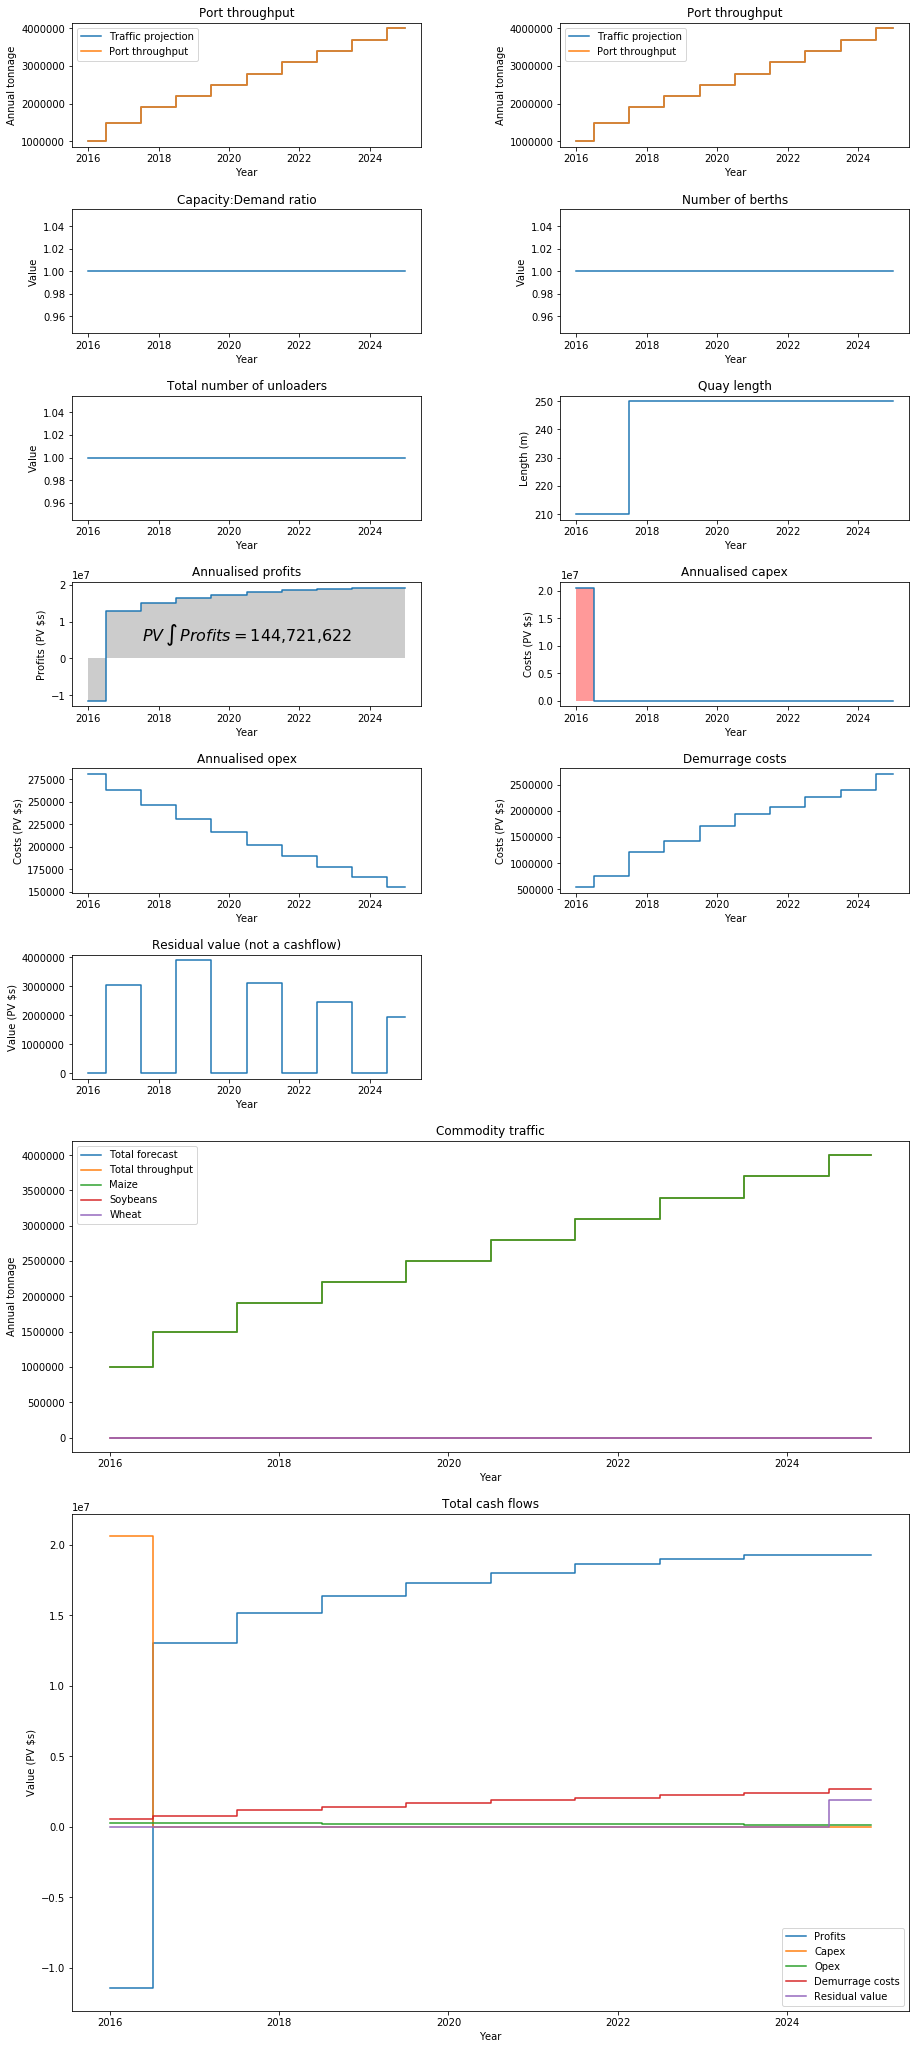

In [45]:
optimal_configuration(2)